In [1]:
import proplot as plot
import numpy as np
import yaml
import glob

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import logging
import sys

import pizza_cutter

logging.basicConfig(stream=sys.stdout)
for code in ["ngmix", "metadetect", "pizza_cutter", "pizza_cutter_sims"]:
    logging.getLogger(code).setLevel(
        getattr(logging, "WARNING"))

In [3]:
import tempfile
from pizza_cutter_sims.pizza_cutter import run_des_pizza_cutter_coadding_on_sim
from pizza_cutter_sims.sim import generate_sim
from pizza_cutter_sims.constants import PIXEL_SCALE

with open(glob.glob("../runs/run0010_*/config.yaml")[0]) as fp:
    cfg = yaml.safe_load(fp.read())

In [9]:
import tqdm

for _ in tqdm.trange(200):
    seeds = np.random.randint(low=1, high=2**29, size=3)
    rng = np.random.RandomState(seed=seeds[0])
    gal_rng = np.random.RandomState(seed=seeds[1])
    coadd_rng = np.random.RandomState(seed=seeds[2])

    data = generate_sim(
        rng=rng,
        gal_rng=gal_rng,
        coadd_config=cfg["coadd"],
        se_config=cfg["se"],
        psf_config=cfg["psf"],
        gal_config=cfg["gal"],
        layout_config=cfg["layout"],
        msk_config=cfg["msk"],
        shear_config=cfg["shear"],
    )

    with tempfile.TemporaryDirectory() as tmpdir:
        cdata = run_des_pizza_cutter_coadding_on_sim(
            rng=coadd_rng,
            tmpdir=tmpdir,
            single_epoch_config=cfg["pizza_cutter"]["single_epoch_config"],
            **data,
        )

100%|██████████| 200/200 [03:39<00:00,  1.10s/it]


In [5]:
print(seeds)

[ 66078641 217077349 257033570]


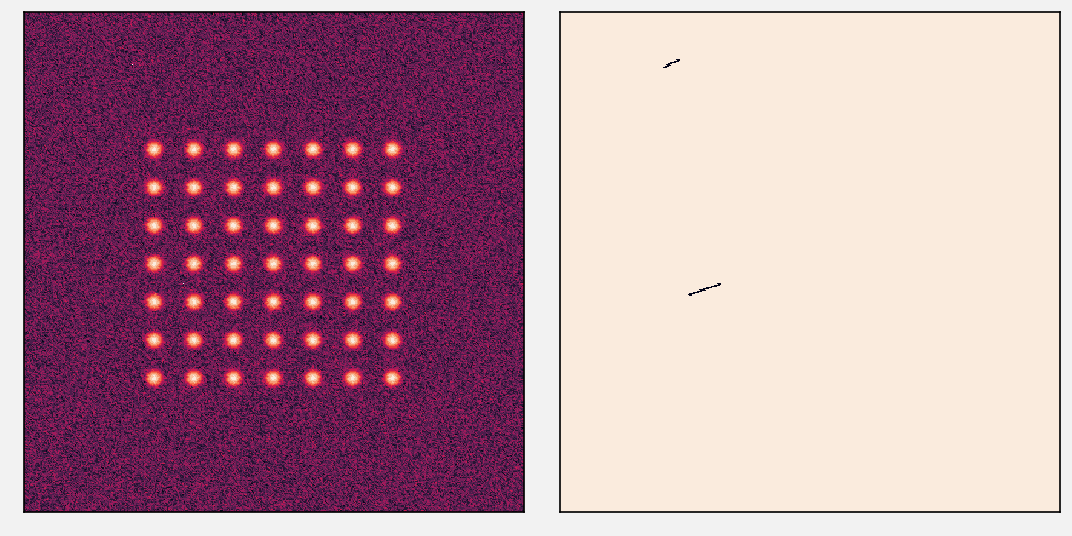

In [6]:
fig, axs = plot.subplots(nrows=len(data["img"]), ncols=2)

for i in range(len(data["img"])):
    
    axs[i, 0].pcolormesh(np.arcsinh(data["img"][i]*np.sqrt(data["wgt"][i])), cmap="rocket")
    axs[i, 0].set_aspect(1)
    axs[i, 0].xaxis.set_visible(False)
    axs[i, 0].yaxis.set_visible(False)
    axs[i, 1].pcolormesh(data["msk"][i], cmap="rocket_r")
    axs[i, 1].set_aspect(1)
    axs[i, 1].xaxis.set_visible(False)
    axs[i, 1].yaxis.set_visible(False)


In [7]:
coadd_rng = np.random.RandomState(seed=seeds[2])

with tempfile.TemporaryDirectory() as tmpdir:
    cdata = run_des_pizza_cutter_coadding_on_sim(
        rng=coadd_rng,
        tmpdir=tmpdir,
        single_epoch_config=cfg["pizza_cutter"]["single_epoch_config"],
        **data,
    )

In [8]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.


In [ ]:
np.unique(data["msk"])

In [ ]:
import tempfile
from pizza_cutter_sims.pizza_cutter import run_des_pizza_cutter_coadding_on_sim

coadd_rng = np.random.RandomState(seed=57)
with tempfile.TemporaryDirectory() as tmpdir:
    cdata = run_des_pizza_cutter_coadding_on_sim(
        rng=coadd_rng,
        tmpdir=tmpdir,
        single_epoch_config=cfg["pizza_cutter"]["single_epoch_config"],
        **data,
    )

In [ ]:
fig, axs = plot.subplots(nrows=3, ncols=2, figsize=(8, 8), share=0)

for i, key in enumerate(["image", "bmask", "ormask", "noise", "psf", "weight"]):
    
    axs[i].pcolormesh(cdata[key], cmap="rocket")
    axs[i].set_aspect(1)
    axs[i].set_title(key)


In [ ]:
fig, axs = plot.subplots(nrows=1, ncols=1, figsize=(8, 8), share=0)
axs.pcolormesh(cdata["rsd"][0]["image"] - cdata["rsd"][1]["image"], cmap="rocket")

In [ ]:
flags = 0
flags |= 1
flags |= 2
print(flags)